### **Pyspark Classification Analysis**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import numpy as np

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array

# **‬Part 1: Data Exploration and Overview‬**

## Data Loading and Inspection

- Load the dataset and display the first five rows.
  
- Rename the columns as follows:
  - `'Total Area'` → `'Seed Area'`
  - `'Boundary Length'` → `'Seed Perimeter'`
  - `'Max Length'` → `'Long_Axis_Length'`
  - `'Min Length'` → `'Short_Axis_Length'`
  - `'Seed Eccentricity'` → `'Seed_Eccentricity'`
  - `'Convex Boundary Area'` → `'Convex_Hull_Area'`
  - `'Coverage Ratio'` → `'Bounding_Box_Extent'`
  - `'Circular Diameter'` → `'Equivalent_Diameter'`
  - `'Shape Ratio'` → `'Shape_Compactness'`
  - `'Convexity Factor'` → `'Shape_Solidity'`


In [4]:
spark = SparkSession.builder \
    .appName("SunFlowerAnalysis") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.7") \
    .getOrCreate()

file_path = "Sunflower_Seeds_Dataset.xlsx"

df = spark.read \
    .format("com.crealytics.spark.excel") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("sheetName", "Sunflower_Seeds_Dataset") \
    .load(file_path)

df.show(5)

display(df.toPandas().head())


24/10/27 19:00:07 WARN Utils: Your hostname, Mukunds-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.149 instead (on interface en0)
24/10/27 19:00:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/mukundkomati/.ivy2/cache
The jars for the packages stored in: /Users/mukundkomati/.ivy2/jars
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-575771da-fb25-4a1c-a494-2ac3ee5ecfe2;1.0
	confs: [default]
	found com.crealytics#spark-excel_2.12;0.13.7 in central
	found org.apache.poi#poi;4.1.2 in central
	found commons-codec#commons-codec;1.13 in central


:: loading settings :: url = jar:file:/Users/mukundkomati/spark3/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;4.1.2 in central
	found org.apache.poi#poi-ooxml-schemas;4.1.2 in central
	found org.apache.xmlbeans#xmlbeans;3.1.0 in central
	found com.github.virtuald#curvesapi;1.06 in central
	found com.norbitltd#spoiwo_2.12;1.8.0 in central
	found org.scala-lang.modules#scala-xml_2.12;1.3.0 in central
	found com.github.pjfanning#excel-streaming-reader;2.3.6 in central
	found com.github.pjfanning#poi-shared-strings;1.0.4 in central
	found com.h2database#h2;1.4.200 in central
	found org.apache.commons#commons-text;1.8 in central
	found org.apache.commons#commons-lang3;3.9 in central
	found xml-apis#xml-apis;1.4.01 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.apache.commons#commons-compress;1.20 in central
:: resolution report :: resolve 188ms :: artifacts dl 8ms
	:: modules in use:
	

+----------+---------------+----------+----------+--------------------+-----------------+-----------------+----------------+--------------+---------------+-------------+-----------+------------+
|Total Area|Boundary Length|Max Length|Min Length|Convex Boundary Area|Circular Diameter|Seed Eccentricity|Convexity Factor|Coverage Ratio|Shape Roundness|Ovality Index|Shape Ratio|       Class|
+----------+---------------+----------+----------+--------------------+-----------------+-----------------+----------------+--------------+---------------+-------------+-----------+------------+
|   56276.0|        888.242|  326.1485|  220.2388|             56831.0|         267.6805|           0.7376|          0.9902|        0.7453|         0.8963|       1.4809|     0.8207|High_Quality|
|   76631.0|       1068.146|  417.1932|  234.2289|             77280.0|         312.3614|           0.8275|          0.9916|        0.7151|          0.844|       1.7811|     0.7487|High_Quality|
|   71623.0|       1082.9

,Total Area,Boundary Length,Max Length,Min Length,Convex Boundary Area,Circular Diameter,Seed Eccentricity,Convexity Factor,Coverage Ratio,Shape Roundness,Ovality Index,Shape Ratio,Class
0,56276.00,888.24,326.15,220.24,56831.00,267.68,0.74,0.99,0.75,0.90,1.48,0.82,High_Quality
1,76631.00,1068.15,417.19,234.23,77280.00,312.36,0.83,0.99,0.72,0.84,1.78,0.75,High_Quality
2,71623.00,1082.99,435.83,211.05,72663.00,301.98,0.87,0.99,0.74,0.77,2.07,0.69,High_Quality
3,66458.00,992.05,381.56,222.53,67118.00,290.89,0.81,0.99,0.74,0.85,1.71,0.76,High_Quality
4,66107.00,998.15,383.89,220.45,67117.00,290.12,0.82,0.98,0.68,0.83,1.74,0.76,High_Quality


### Rename the columns

In [5]:
df = df.withColumnRenamed('Total Area', 'Seed_Area') \
       .withColumnRenamed('Boundary Length', 'Seed_Perimeter') \
       .withColumnRenamed('Max Length', 'Long_Axis_Length') \
       .withColumnRenamed('Min Length', 'Short_Axis_Length') \
       .withColumnRenamed('Seed Eccentricity', 'Seed_Eccentricity') \
       .withColumnRenamed('Convex Boundary Area', 'Convex_Hull_Area') \
       .withColumnRenamed('Coverage Ratio', 'Bounding_Box_Extent') \
       .withColumnRenamed('Circular Diameter', 'Equivalent_Diameter') \
       .withColumnRenamed('Shape Ratio', 'Shape_Compactness') \
       .withColumnRenamed('Convexity Factor', 'Shape_Solidity') \
        .withColumnRenamed('Ovality Index', 'Aspect_Ratio') \
        .withColumnRenamed('Shape Roundness', 'Shape_Roundness')

df.show(5)

+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+------------+
|Seed_Area|Seed_Perimeter|Long_Axis_Length|Short_Axis_Length|Convex_Hull_Area|Equivalent_Diameter|Seed_Eccentricity|Shape_Solidity|Bounding_Box_Extent|Shape_Roundness|Aspect_Ratio|Shape_Compactness|       Class|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+------------+
|  56276.0|       888.242|        326.1485|         220.2388|         56831.0|           267.6805|           0.7376|        0.9902|             0.7453|         0.8963|      1.4809|           0.8207|High_Quality|
|  76631.0|      1068.146|        417.1932|         234.2289|         77280.0|           312.3614|           0.8275|        0.9916|             0.7151| 

## Dataset Overview

- Report the size of the dataset (number of rows and columns).
  
- Display the data types for each column.
  
- Show the unique values present in the target column (Quality).


In [6]:
row_count = df.count()
column_count = len(df.columns)
print(f"Dataset size: {row_count} rows and {column_count} columns")

df.printSchema()

df.select("Class").distinct().show()

Dataset size: 2500 rows and 13 columns
root
 |-- Seed_Area: double (nullable = true)
 |-- Seed_Perimeter: double (nullable = true)
 |-- Long_Axis_Length: double (nullable = true)
 |-- Short_Axis_Length: double (nullable = true)
 |-- Convex_Hull_Area: double (nullable = true)
 |-- Equivalent_Diameter: double (nullable = true)
 |-- Seed_Eccentricity: double (nullable = true)
 |-- Shape_Solidity: double (nullable = true)
 |-- Bounding_Box_Extent: double (nullable = true)
 |-- Shape_Roundness: double (nullable = true)
 |-- Aspect_Ratio: double (nullable = true)
 |-- Shape_Compactness: double (nullable = true)
 |-- Class: string (nullable = true)

+------------+
|       Class|
+------------+
|High_Quality|
| Low_Quality|
+------------+



In [7]:
null_report = df.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df.columns])
null_report.show()
null_report.toPandas()

+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+-----+
|Seed_Area|Seed_Perimeter|Long_Axis_Length|Short_Axis_Length|Convex_Hull_Area|Equivalent_Diameter|Seed_Eccentricity|Shape_Solidity|Bounding_Box_Extent|Shape_Roundness|Aspect_Ratio|Shape_Compactness|Class|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+-----------------+-----+
|        0|             0|               0|                0|               0|                  0|                0|             0|                  0|              0|           0|                0|    0|
+---------+--------------+----------------+-----------------+----------------+-------------------+-----------------+--------------+-------------------+---------------+------------+

,Seed_Area,Seed_Perimeter,Long_Axis_Length,Short_Axis_Length,Convex_Hull_Area,Equivalent_Diameter,Seed_Eccentricity,Shape_Solidity,Bounding_Box_Extent,Shape_Roundness,Aspect_Ratio,Shape_Compactness,Class
0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Part 2: Summary Statistics‬**


## Descriptive Statistics

- For numerical columns, provide a statistical summary, including minimum, maximum, variance, and standard deviation.
  
- Identify and analyze potential outliers in the data and explain how they will be treated.


In [8]:
num_cols = [field.name for field in df.schema.fields if field.dataType.typeName() != 'string']

In [9]:
num_cols

['Seed_Area',
 'Seed_Perimeter',
 'Long_Axis_Length',
 'Short_Axis_Length',
 'Convex_Hull_Area',
 'Equivalent_Diameter',
 'Seed_Eccentricity',
 'Shape_Solidity',
 'Bounding_Box_Extent',
 'Shape_Roundness',
 'Aspect_Ratio',
 'Shape_Compactness']

In [10]:
var_describe = df.select([F.var_pop(F.col(x)).alias(x) for x in num_cols])\
                .withColumn('summary', F.lit("var"))\
                .select(['summary'] + num_cols)
other_describe = df.select(num_cols).describe()\
.filter(F.col('summary').isin(['mean', 'min', 'max', 'stddev']))
stat_report = other_describe.union(var_describe)
stat_report.show()
stat_report.toPandas()

24/10/27 19:00:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|summary|           Seed_Area|    Seed_Perimeter|  Long_Axis_Length| Short_Axis_Length|    Convex_Hull_Area|Equivalent_Diameter|   Seed_Eccentricity|      Shape_Solidity| Bounding_Box_Extent|     Shape_Roundness|       Aspect_Ratio|   Shape_Compactness|
+-------+--------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|   mean|          80658.2208|      1130.2790148|456.60184016000005|      225.79492116|          81508.0844|          319.33423|  0.8608793999999999|  0.9894915999999999|  0.6932045200000001|  0.7915327600000003|         2.04170232|  0.70

,summary,Seed_Area,Seed_Perimeter,Long_Axis_Length,Short_Axis_Length,Convex_Hull_Area,Equivalent_Diameter,Seed_Eccentricity,Shape_Solidity,Bounding_Box_Extent,Shape_Roundness,Aspect_Ratio,Shape_Compactness
0,mean,80658.2208,1130.2790148,456.60184016000005,225.79492116,81508.0844,319.33423,0.8608793999999999,0.9894915999999999,0.6932045200000001,0.7915327600000003,2.04170232,0.7041205199999998
1,stddev,13664.51022838213,109.25641774887872,56.235703949818074,23.297244577915173,13764.092788258515,26.89191972981047,0.04516739852145214,0.003493592351005752,0.06091364803208089,0.055923946623112786,0.31599688383092256,0.05306688493439434
2,min,47939.0,868.485,320.8446,152.1718,48366.0,247.0584,0.4921,0.9186,0.468,0.5546,1.1487,0.5608
3,max,136574.0,1559.45,661.9113,305.818,138384.0,417.0029,0.9481,0.9944,0.8296,0.9396,3.1444,0.9049
4,var,1.8664415224564725E8,11932.190033389772,3161.189416972091,542.5445002812286,1.8937447018367654E8,722.8860766158679,0.002039277851639999,1.2200305439999897E-5,0.003708988327569602,0.0031262368107824057,0.09981408897861724,0.002814967838929593


### Identify and analyze potential outliers in the data and explain how they will be treated.

In [11]:
#function to find outlier percentage
def get_outliers_per(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))
    return 100 * res.count() / df.count()

#function for plotting outliers
def plot_outliers(df, col_names):
    n_cols = 3  # Number of columns in the subplot
    n_rows = (len(col_names) + n_cols - 1) // n_cols  # Calculate rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)

    axes = axes.flatten()

    for i, col_name in enumerate(col_names):
        outlier_per = get_outliers_per(df, col_name)
        pandas_df = df.select(col_name).toPandas()  # Convert to pandas DataFrame
        sns.boxplot(x=pandas_df[col_name], ax=axes[i])  # Create box plot on the respective subplot
        axes[i].set_title("Box Plot of {a} (Outlier % : {b})".format(a = col_name, b = outlier_per))

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

#function for replacing outliers with median
def replace_outliers_median(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    median = df.approxQuantile(col_name, [0.5], 0.01)[0]
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))

    df = df.withColumn(col_name, F.when((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound), median)\
                       .otherwise(F.col(col_name)))
    
    return df

#function for replacing outliers with capping
def replace_outliers_capping(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    median = df.approxQuantile(col_name, [0.5], 0.01)[0]
    iqr = q3-q1
    
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    res = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound))

    df = df.withColumn(col_name, F.when((F.col(col_name) < lower_bound), lower_bound)\
                       .otherwise(F.col(col_name)))
    df = df.withColumn(col_name, F.when((F.col(col_name) > upper_bound), upper_bound)\
                       .otherwise(F.col(col_name)))
    return df

#### Box plot to identify outliers

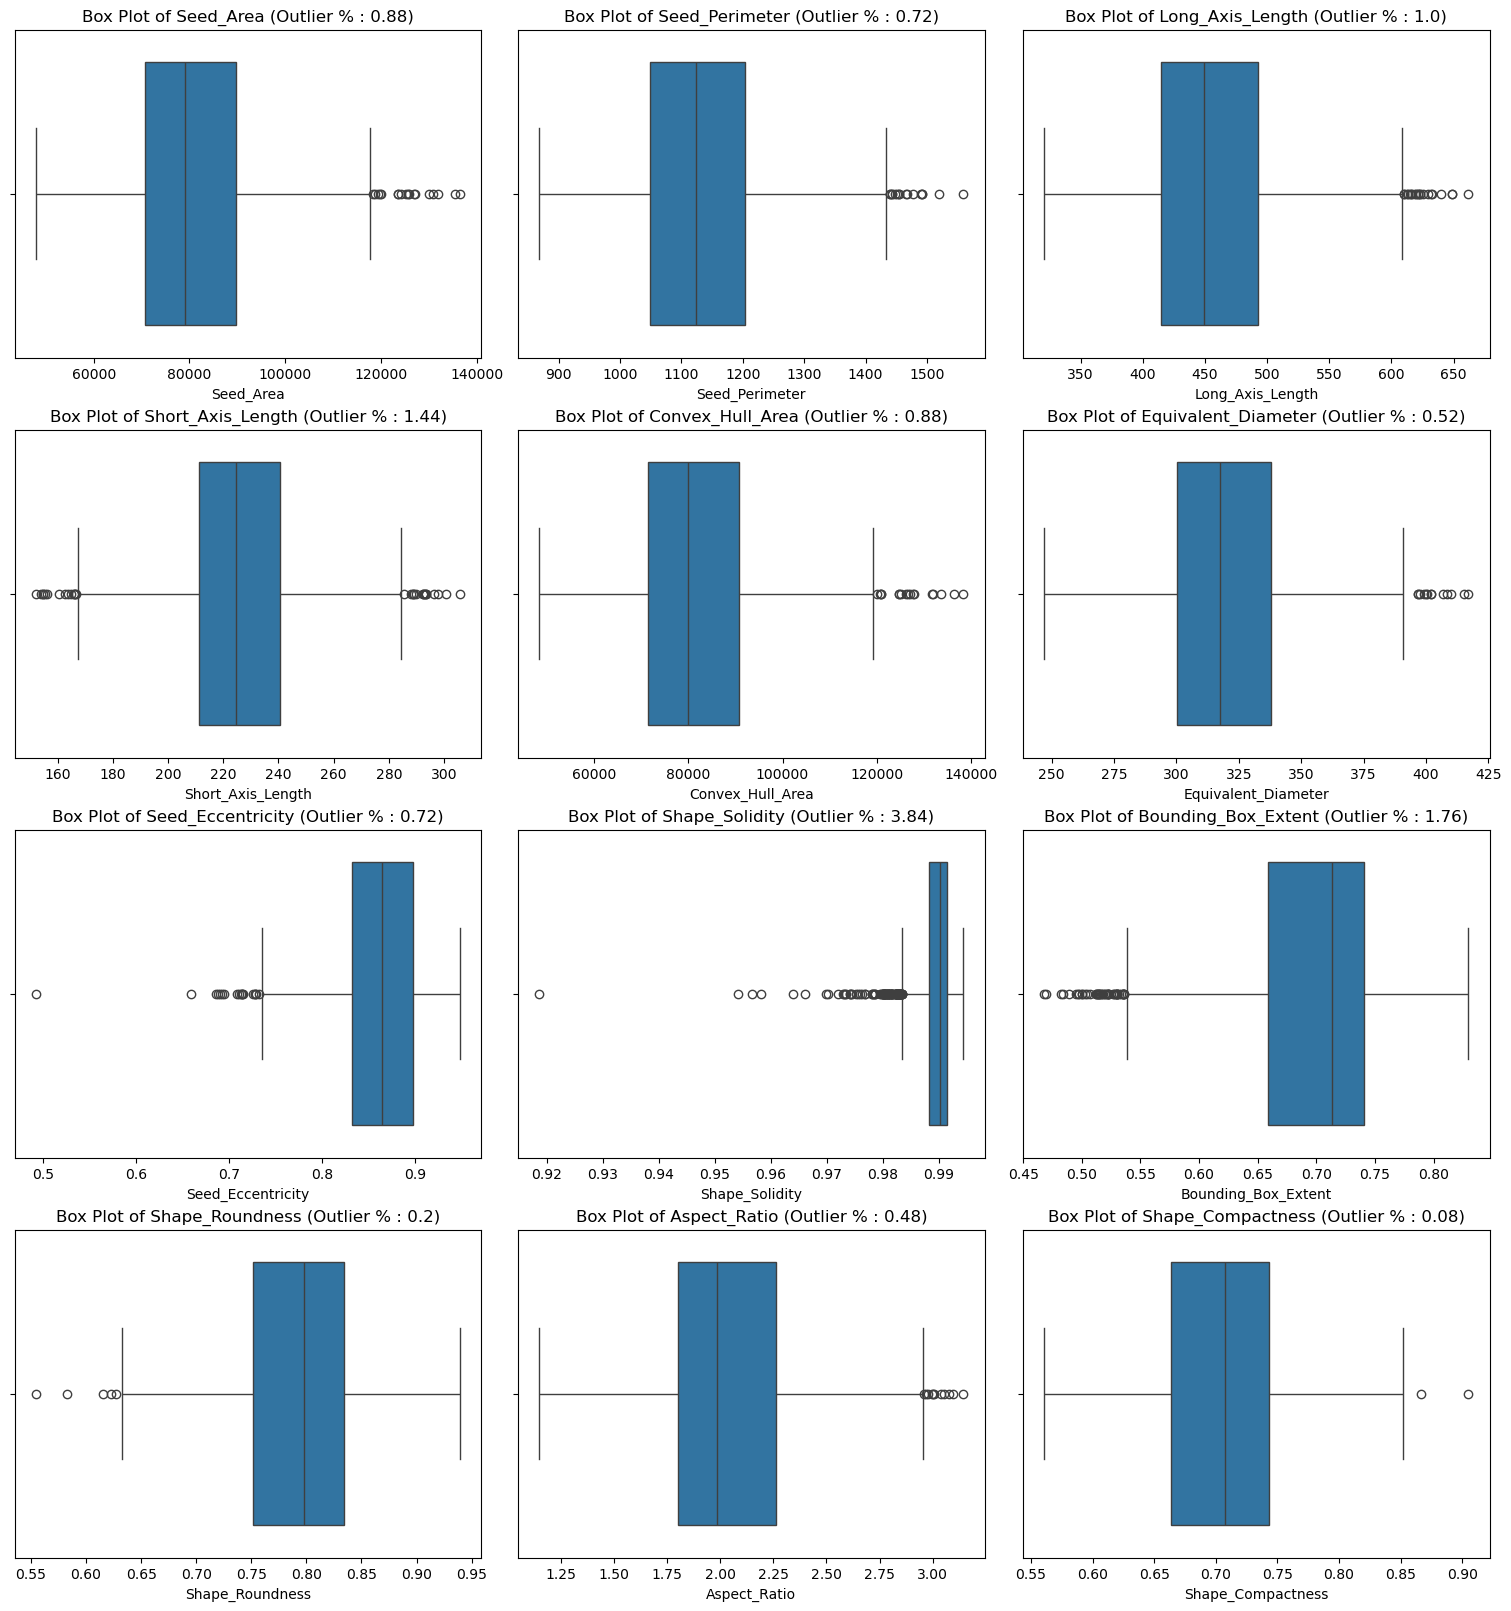

In [12]:
plot_outliers(df, num_cols)

#### Histogram plots to analyse distribution

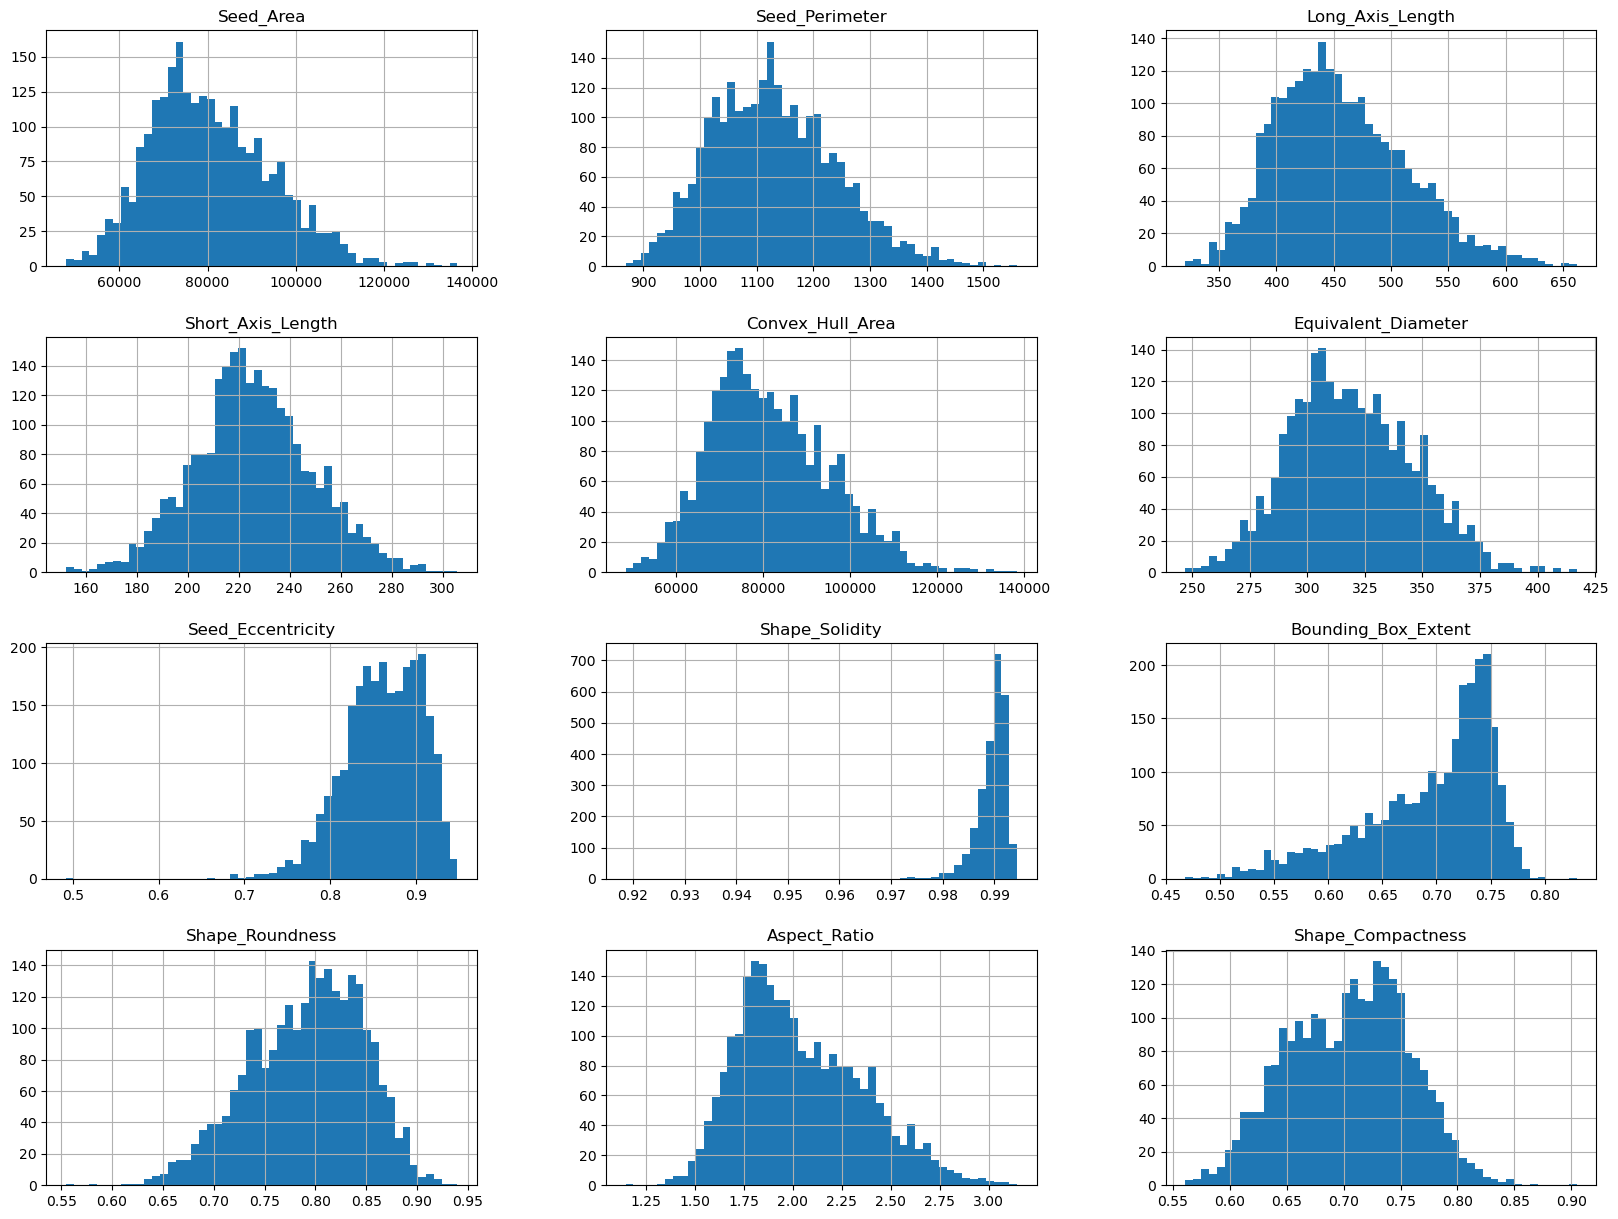

In [13]:
df.toPandas().hist(bins=50,figsize=(20,15)) # Plotting histogram for all attributes
plt.show()

#### All features have been imputed using the **Capping Method**. This approach adjusts extreme values within a reasonable range without discarding any data, preserving distribution and maintaining data integrity—particularly important for smaller datasets. Unlike median imputation, capping retains the data's original structure and variability, making it more effective for skewed data and providing a more accurate foundation for analysis and modeling.

In [14]:
#upper bound lower bound replacement
for i in num_cols:
    df = replace_outliers_capping(df, i)

#### Confirming Outlier Removal

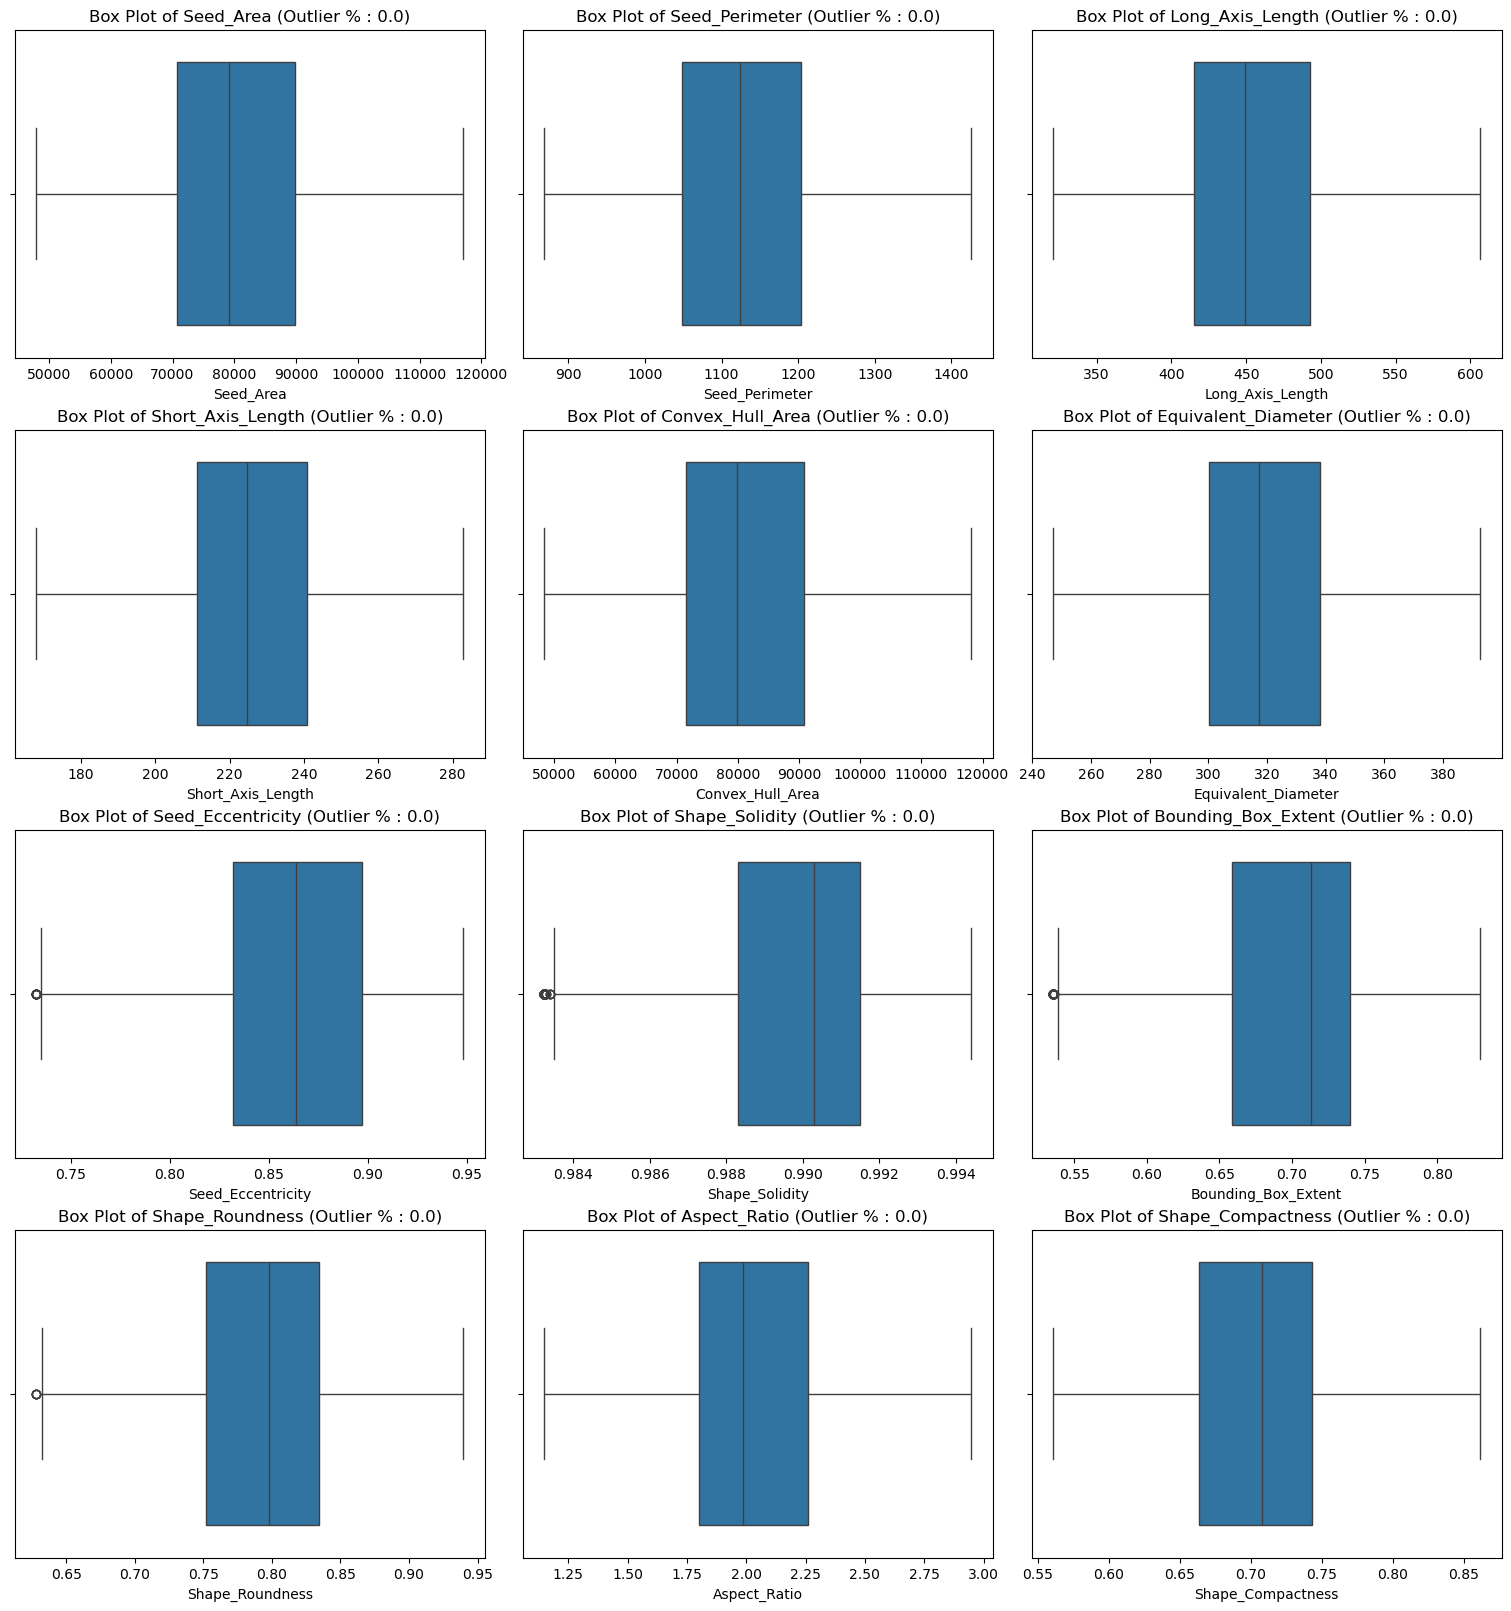

In [15]:
plot_outliers(df, num_cols)

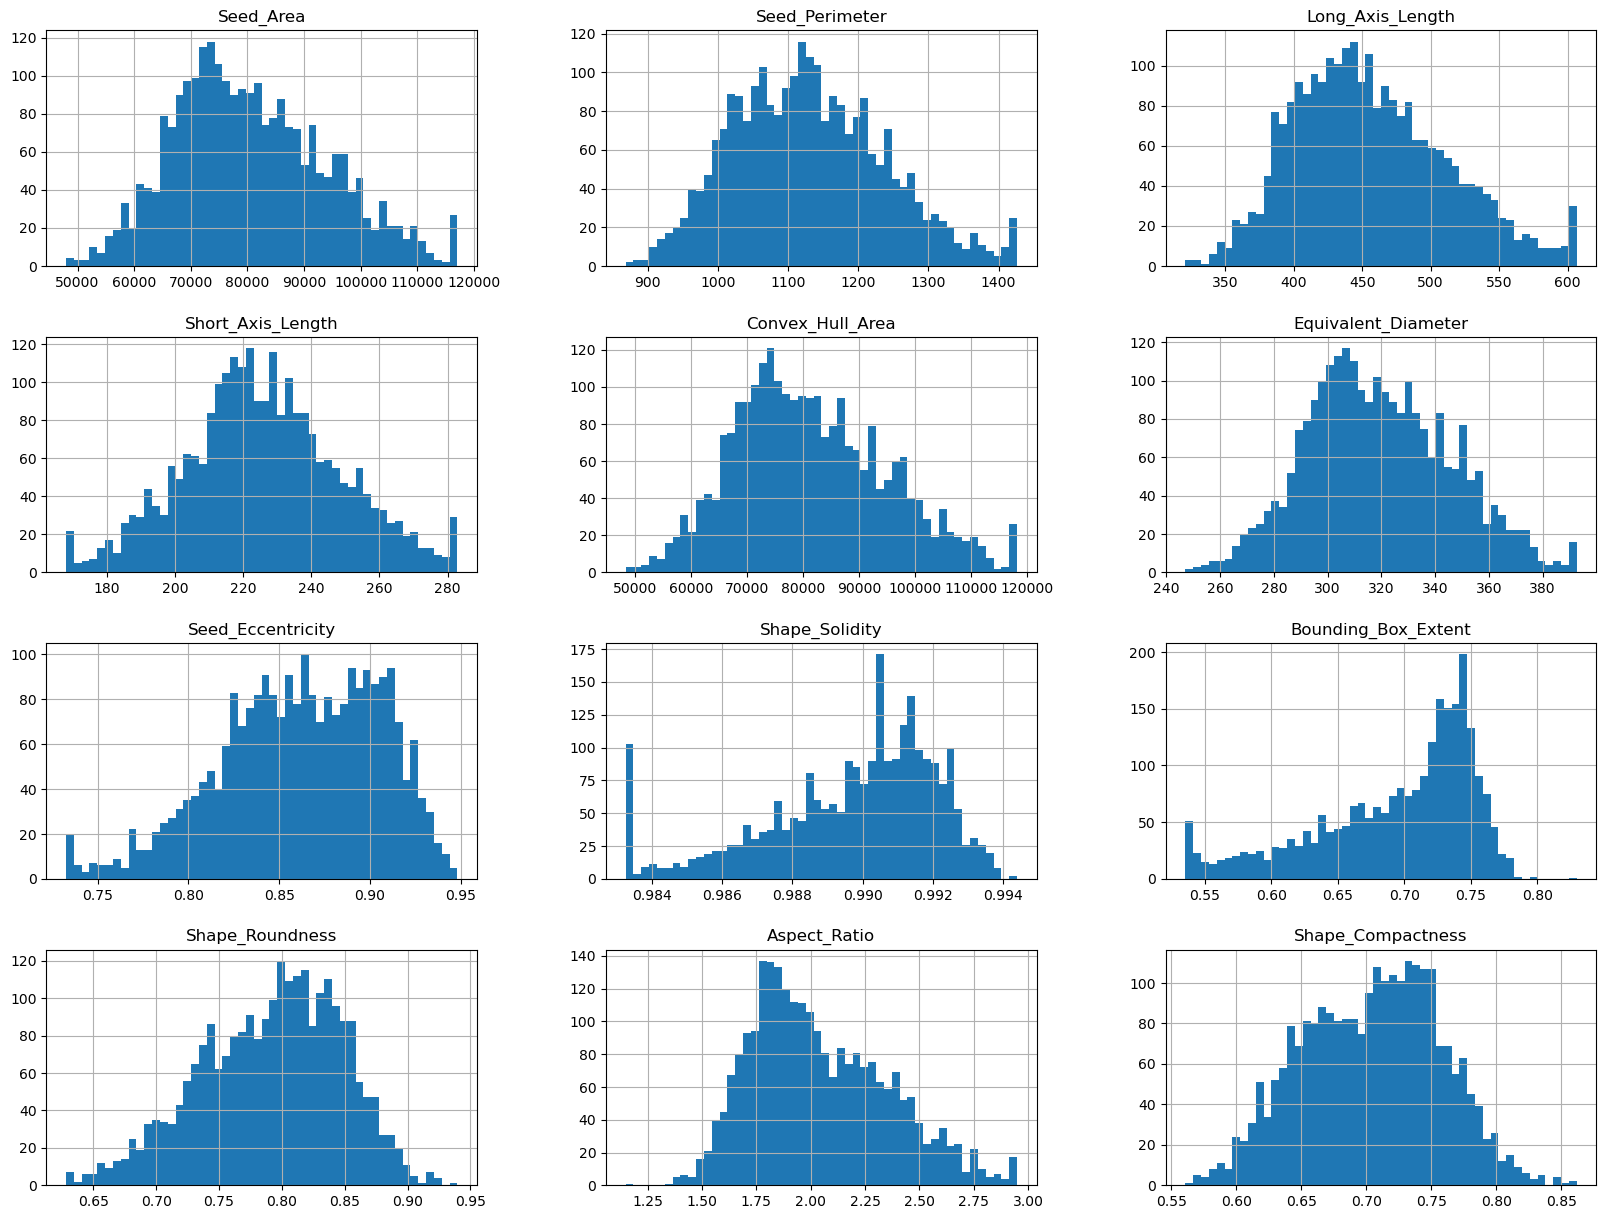

In [16]:
df.toPandas().hist(bins=50,figsize=(20,15)) # Plotting histogram for all attributes
plt.show()

#### Distribution of Label (Class)

In [17]:
for i in ['Class']:
    df.groupBy(i).count()\
        .orderBy(F.desc("count"))\
        .withColumn('%', (100*F.col('count')/df.count()))\
        .drop('count')\
        .show()

+------------+----+
|       Class|   %|
+------------+----+
|High_Quality|52.0|
| Low_Quality|48.0|
+------------+----+



# **Part 3: Feature Engineering and Scaling**

## Feature Scaling

- Analyze whether normalization or standardization is required for the dataset.
  
- Apply the appropriate scaling method (if needed) and explain your decision.


#### StandardScaler standardizes features by eliminating the mean and scaling them to have unit variance, resulting in each feature having a mean of 0 and a standard deviation of 1. As most features are already normally distributed, StandardScaler preserves this distribution while ensuring all features are on a consistent scale. 
#### Here, standard Scaling will be applied to the features after splitting the dataset into training and testing sets in order to prevent data leakage.

## Relationship Between Features

- Perform a correlation analysis to identify relationships between numerical features and the Class.
  
- Comment on any strong correlations or patterns that you observe.


#### Encoding Class Label Column to 0 ('Low Quality') and 1 ('High Quality')

In [18]:
df = df.withColumn('class_indexed', F.when(df['Class'] == 'High_Quality', 1.00).otherwise(0.00))
df = df.drop('Class')

In [19]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def get_correlation_matrix_spark(df):
    # convert to vector column first
    dim = len(df.columns)
    cols = df.columns
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    
    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    matrix = matrix.collect()[0]['pearson(corr_features)'].values
    matrix = matrix.reshape((dim,dim))
    matrix_df = pd.DataFrame(matrix, columns = cols)
    matrix_df.index = cols

    plt.figure(figsize=(10, 8))

    # Plot the heatmap
    sns.heatmap(matrix_df, 
                annot=True,            # Displays the correlation values in the plot
                cmap='RdBu',           # Color scale for the heatmap
                center=0,              # Centering the colormap around 0
                vmin=-1, vmax=1,       # Setting the color bar limits
                linewidths=0.5,        # Adding space between squares
                fmt=".2f",             # Formatting the annotations
                square=True)           # Make the cells square-shaped

    # Add title
    plt.title("Correlation Matrix", size=16)

    # Show the plot
    plt.show()
    
    return
    

#### Plotting Correlation Matrix to identify highly correlated variables 

24/10/27 19:00:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


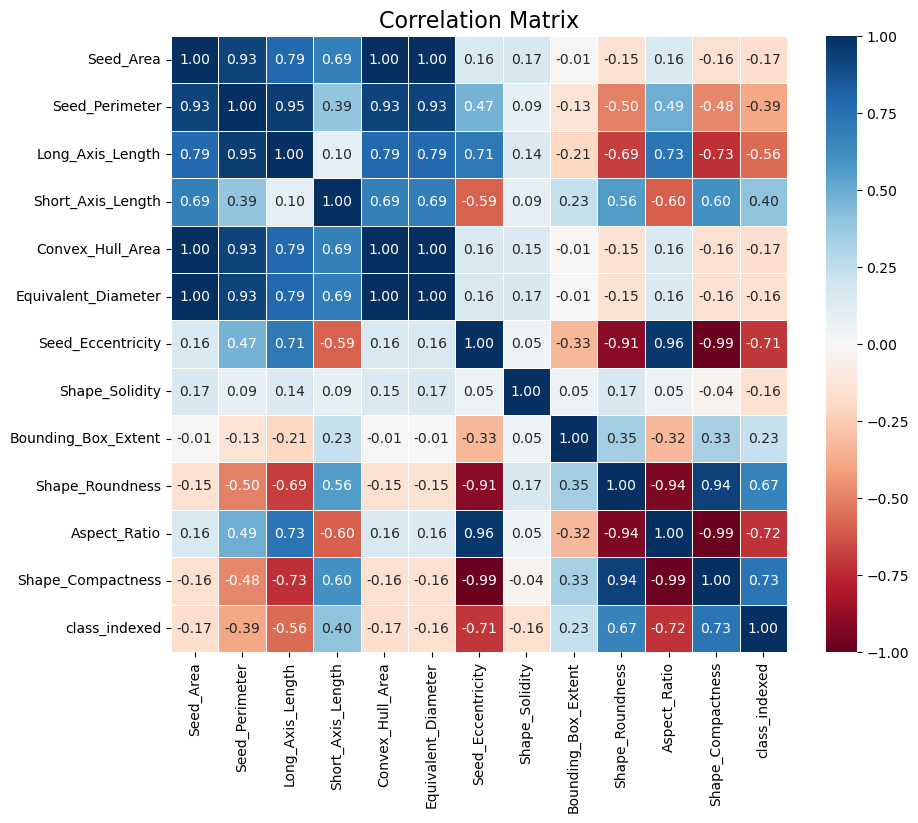

In [20]:
get_correlation_matrix_spark(df)

#### Highly Correlated Variables

The following pairs of variables have high correlations (close to or above |0.90|), suggesting that they contain similar information:

- **Seed_Area and Convex_Hull_Area** 
- **Seed_Perimeter and Long_Axis_Length**
- **Shape_Compactness and Shape_Roundness**
- **Aspect_Ratio and Shape_Compactness**
- **Seed_Eccentricity and Shape_Roundness**

#### Dropping Variables

To reduce redundancy

- **Drop Convex_Hull_Area or Seed_Area**
- **Drop Long_Axis_Length or Seed_Perimeter**
- **Drop Shape_Compactness**
- **Drop Equivalent_Diameters**
- **Drop Shape_Roundness**
- **Drop Seed_Eccentricity**

Highly correlated variables with the target label like **Aspect_Ratio** and **Long_Axis_Length** are NOT dropped

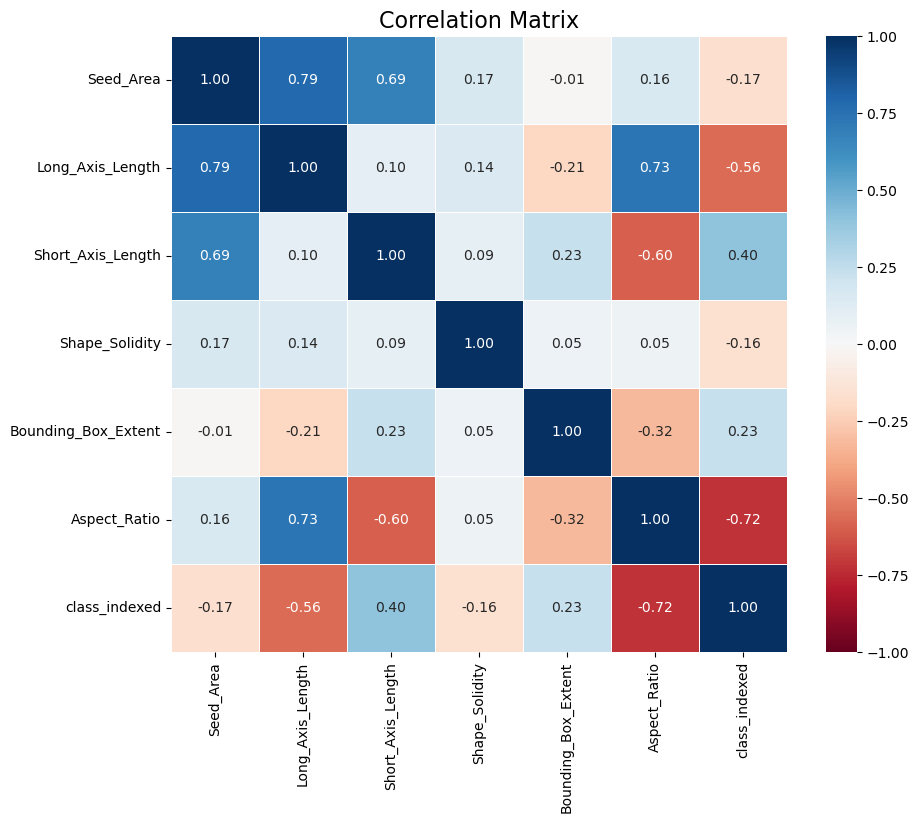

In [21]:
drop_cols = ['Convex_Hull_Area', 'Seed_Perimeter', 'Shape_Compactness', 'Equivalent_Diameter', 'Shape_Roundness', 'Seed_Eccentricity']
for i in drop_cols:
    df = df.drop(i)
get_correlation_matrix_spark(df)

# **Part 4: Classification Modeling**

### Data Preprocessing for Classification
- Split the dataset into training and testing sets. Ensure that the split maintains a‬ ‭ similar distribution of the target variable across both sets.‬

In [22]:
df_binned = df.withColumn('id', F.monotonically_increasing_id())

fractions = {category: 0.75 for category in df_binned.select("class_indexed").distinct().rdd.flatMap(lambda x: x).collect()}
fractions

{1.0: 0.75, 0.0: 0.75}

In [23]:
#performing stratified sampling
df_train = df_binned.sampleBy("class_indexed", fractions, seed=42)
df_test = df_binned.subtract(df_train)

In [24]:
df_train.count()/df_binned.count()

0.7564

In [25]:
df_train.count() + df_test.count()

2500

In [26]:
df_binned.count()

2500

In [27]:
df_train.groupBy('class_indexed').count()\
        .orderBy(F.desc("count"))\
        .withColumn('%', (100*F.col('count')/df_train.count()))\
        .drop('count')\
        .show()

+-------------+-----------------+
|class_indexed|                %|
+-------------+-----------------+
|          1.0|51.71866737176097|
|          0.0|48.28133262823903|
+-------------+-----------------+



In [28]:
df_test.groupBy('class_indexed').count()\
        .orderBy(F.desc("count"))\
        .withColumn('%', (100*F.col('count')/df_test.count()))\
        .drop('count')\
        .show()

+-------------+-----------------+
|class_indexed|                %|
+-------------+-----------------+
|          1.0|52.87356321839081|
|          0.0|47.12643678160919|
+-------------+-----------------+



#### % of (High Quality and Low Quality) is similar accross train and test datasets, ensuring similar distribution of the target variable across both sets.

### Feature Scaling using standard scaler (from part 3)

In [29]:
def vectorize(cols, df):
    vectorAssembler = VectorAssembler(inputCols = cols, outputCol = 'features')
    df_vectorized = vectorAssembler.transform(df.select(cols))
    return df_vectorized

In [30]:
from pyspark.ml.feature import MinMaxScaler
def scale_minmax(scaler_cols, df):
    df_vectorized = vectorize(scaler_cols, df)
    mm = MinMaxScaler(inputCol = 'features', outputCol = 'mm_scaled_features')
    mm = mm.fit(df_vectorized.select(['features']))
    df_scaled = mm.transform(df_vectorized.select(['features']))
    df_scaled = df_scaled.select('mm_scaled_features')
    df_trans = df_scaled.withColumn('id', F.monotonically_increasing_id())
    return df_trans, mm

In [31]:
from pyspark.ml.feature import StandardScaler
def scale_standard(scaler_cols, df):
    df_vectorized = vectorize(scaler_cols, df)
    sd = StandardScaler(inputCol = 'features', outputCol = 'sd_scaled_features', withMean = True)
    sd = sd.fit(df_vectorized.select(['features']))
    df_scaled = sd.transform(df_vectorized.select(['features']))
    df_scaled = df_scaled.select('sd_scaled_features')
    df_trans = df_scaled.withColumn('id', F.monotonically_increasing_id())
    return df_trans, sd

In [32]:
trans_cols = df_train.columns
trans_cols.remove('class_indexed')
trans_cols.remove('id')

In [33]:
trans_cols

['Seed_Area',
 'Long_Axis_Length',
 'Short_Axis_Length',
 'Shape_Solidity',
 'Bounding_Box_Extent',
 'Aspect_Ratio']

In [34]:
df_train_trans, num_scaler = scale_standard(trans_cols, df_train)

In [35]:
df_test_trans = vectorize(trans_cols, df_test)
df_test_trans = num_scaler.transform(df_test_trans.select(['features']))
df_test_trans = df_test_trans.drop('features')
df_test_trans = df_test_trans.withColumn('id', F.monotonically_increasing_id())

In [36]:
def join_nums_cats(df, df_trans):
    df_final = df_trans.join(df.select('class_indexed').withColumn('id', F.monotonically_increasing_id()), on = ['id'], how = 'inner')\
                    .drop('id')
    return df_final

In [37]:
df_train_final = join_nums_cats(df_train, df_train_trans)
df_test_final = join_nums_cats(df_test, df_test_trans)

In [38]:
df_train_final = df_train_final.withColumnRenamed((df_train_final.columns[0]), 'features')
df_test_final = df_test_final.withColumnRenamed((df_test_final.columns[0]), 'features')

## Model Training

- Train two classification models of your choice (e.g., Logistic Regression, Decision Tree, Random Forest, etc.) to predict the target variable (seed quality).
- Using Logitic Regression and Decision Tree Classifier here


#### Logistic Regression Model Training

In [39]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="class_indexed", featuresCol="features")
lr = lr.fit(df_train_final)
train_act_pred_lr = lr.transform(df_train_final)
test_act_pred_lr = lr.transform(df_test_final)

#### Decision Tree Classifier Training

In [40]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features',labelCol="class_indexed")
dt = dt.fit(df_train_final)
train_act_pred_dt = dt.transform(df_train_final)
test_act_pred_dt = dt.transform(df_test_final)

## Model Evaluation

- Evaluate the models using classification metrics such as:
  - Accuracy
  - Precision
  - Recall
  - F1-Score
  - AUC-ROC
- Compare the performance of both models.

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
def get_eval_metric(metric_type, actual_pred):
    prediction_and_label = actual_pred.select(['prediction', 'class_indexed'])
    # Create MulticlassMetrics object
    metrics = MulticlassMetrics(prediction_and_label.rdd.map(tuple))
    # metrics
    print("Accuracy:", metrics.accuracy)
    print("Precision:", metrics.precision(1.0))
    print("Recall:", metrics.recall(1.0))
    print("F1 measure:", metrics.fMeasure(1.0))
    for metric_type in ['areaUnderROC']:
        evaluator = BinaryClassificationEvaluator(labelCol="class_indexed", rawPredictionCol="rawPrediction", metricName = metric_type)
        metric_value = evaluator.evaluate(actual_pred)
        print("({}) : {:.3f}".format(metric_type, metric_value))
    return

#### Logistic Regression Performance

In [42]:
#TRAIN metrics
get_eval_metric(i, train_act_pred_lr)

Accuracy: 0.8799576943416182
Precision: 0.8699507389162562
Recall: 0.9028629856850716
F1 measure: 0.8861013547415957
(areaUnderROC) : 0.940


In [43]:
#TEST metrics
get_eval_metric(i, test_act_pred_lr)

Accuracy: 0.8866995073891626
Precision: 0.8844984802431611
Recall: 0.9037267080745341
F1 measure: 0.8940092165898617
(areaUnderROC) : 0.936


#### Decision Tree Classifier Performance

In [44]:
#TRAIN metrics
get_eval_metric(i, train_act_pred_dt)

Accuracy: 0.893707033315706
Precision: 0.8936170212765957
Recall: 0.901840490797546
F1 measure: 0.8977099236641222
(areaUnderROC) : 0.929


In [45]:
#TEST metrics
get_eval_metric(i, test_act_pred_dt)

Accuracy: 0.8604269293924466
Precision: 0.8859934853420195
Recall: 0.84472049689441
F1 measure: 0.8648648648648649
(areaUnderROC) : 0.901


#### **Initial Comparision** : Test accuracy of Logistic Regression model high as compared to Decision Tree Classifier 

# **Part 5: Model Comparison and Insights**


## Model Performance Comparison

| Metric          | Logistic Regression (Train) | Logistic Regression (Test) | Decision Tree (Train) | Decision Tree (Test) |
|-----------------|-----------------------------|----------------------------|-----------------------|----------------------|
| Accuracy        | 0.880                       | 0.887                      | 0.894                 | 0.860                |
| Precision       | 0.870                       | 0.885                      | 0.893                 | 0.886                |
| Recall          | 0.903                       | 0.904                      | 0.901                 | 0.844                |
| F1 Measure      | 0.886                       | 0.894                      | 0.897                 | 0.864                |
| Area Under ROC  | 0.940                       | 0.936                      | 0.929                 | 0.901                |

### Key Insights

1. **Logistic Regression:**
   - **Test Performance:** Shows slightly better generalization with higher test accuracy (0.887) and F1 score (0.894) compared to the decision tree.
   - **Area Under ROC:** Higher AUC for both train (0.940) and test (0.936), indicating better overall classification performance.

2. **Decision Tree:**
   - **Training Performance:** Slightly higher training accuracy (0.894) and F1 score (0.897), suggesting it fits the training data well.
   - **Test Performance:** Lower test accuracy (0.860) and F1 score (0.864), indicating potential overfitting.

### Suggestions for Improvement

- **For Logistic Regression:**
  - Consider feature scaling or regularization adjustments to further enhance performance.
  
- **For Decision Tree:**
  - Pruning the tree or setting a maximum depth could help reduce overfitting.
  - Experiment with ensemble methods like Random Forests or Gradient Boosting to improve generalization.

Overall, the logistic regression model performs better in terms of generalization to unseen data, as indicated by its higher test metrics and AUC values.
